# Variational Autoencoder 


#### Disclaimer

ChatGPT was used for some plotting codes and learning PyTorch syntax. Some online public repositories were also used as reference on how to implement variational autoencoders. 


#### References 
1. https://github.com/ac-alpha/VAEs-using-Pytorch

In [66]:
# Standard Packages 
import numpy as np 
import matplotlib.pyplot as plt 

# ML Packages 
import torch 
from torch.autograd import Variable 
import torch.nn.functional as F 
import torchvision 
from torchvision import transforms 
import torch.optim as optim 
from torch import nn 
from torchvision.utils import make_grid


### Quick Model Reference

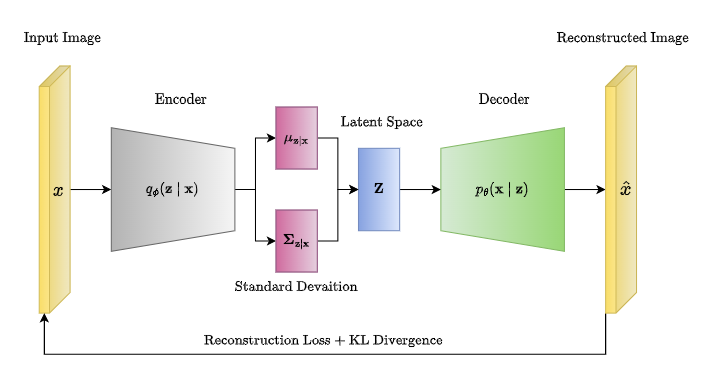

In [2]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder (28 x 28 = 728) 
        self.fc1 = nn.Linear(28*28, 512)

        #Latent Space mu and sigma 
        self.fc2_mu = nn.Linear(512, 2)
        self.fc2_sig = nn.Linear(512, 2)

        # Decoder 
        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)
  
    def encode(self,x):
        a1 = F.relu(self.fc1(x))
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        return a_mu, a_logvar
  
    def decode(self,z):
        a3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(a3))

    # Reparameterization Trick so that we can backpropagate gradients
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

# Obtaining the MNIST DATASET 

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=100, shuffle=False)

# Setting Hyperparameters and the model 

In [4]:
lr = 0.001 

model = VAE()
optimizer = optim.Adam(model.parameters(), lr = lr) 

# Loss Function for VAE 

VAEs use the ELBO loss function. Which is the sum or reconstruction loss and KL Divergence of the variational posterior and prior. 

In [1]:
def loss_function(recon_x, x, mu, logvar):
    '''
    Input: Reconstructed X, X, Mu and Sigma (logvariance) in reparemetrization. 
    Output: ELBO and KLD loss to track the KLD value as well. 
    '''
    # Use Binary Cross Entropy for reconstruction loss. KLD divergence and imposing the variational posterior
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, KLD 

# Training 

In [6]:
num_epochs = 10
print_per = 100

loss_record = [] # ELBO 
KL_loss = [] # KL Divergence 
AVG_loss = [] # Saving per epoch loss
AVG_KL_loss = [] # saving per epoch kl divergence

In [7]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
# Setting the model to Train 
model.train()

# Training 
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    kl_loss = 0
    for i, (images, _) in enumerate(train_loader):
        # Reshape input into proper size 
        images = images.reshape(-1, 28*28)

        # Disable gradients temporarily for mu and sigma 
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss, kl_loss  = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        if (epoch == 0):
            loss_record.append(loss.item())
            KL_loss.append(kl_loss.item()) 
            
        train_loss += loss.item()
        print_loss += loss.item()
        kl_loss += kl_loss.item() 

        # Update 
        optimizer.step()
        
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} ELBO Loss = {:.4f}, KL_Loss = {:.4f}".format(epoch+1, i, print_loss, kl_loss))
#             loss_record.append(print_loss)
            print_loss = 0

    #Average Loss 
    avg_loss = train_loss / len(train_loader.dataset) 
    avg_kl_loss = kl_loss / len(train_loader.dataset) 

    #Appending 
    AVG_loss.append(avg_loss) 
    AVG_KL_loss.append(avg_kl_loss) 
    
    print("Epoch {} : ELBO Loss = ({:.4f}), KL Loss = {:.4f}".format(epoch+1, train_loss, kl_loss))

Epoch : 1 , Minibatch : 0 ELBO Loss = 55196.3203, KL_Loss = 3.3373
Epoch : 1 , Minibatch : 100 ELBO Loss = 2200311.7773, KL_Loss = 1072.5464
Epoch : 1 , Minibatch : 200 ELBO Loss = 1837227.8555, KL_Loss = 1079.6504
Epoch : 1 , Minibatch : 300 ELBO Loss = 1783318.8281, KL_Loss = 992.4565
Epoch : 1 , Minibatch : 400 ELBO Loss = 1736304.9951, KL_Loss = 953.3950
Epoch : 1 , Minibatch : 500 ELBO Loss = 1709507.2803, KL_Loss = 978.8240
Epoch 1 : ELBO Loss = (10982744.5547), KL Loss = 1007.1017
Epoch : 2 , Minibatch : 0 ELBO Loss = 16624.0820, KL_Loss = 1000.2179
Epoch : 2 , Minibatch : 100 ELBO Loss = 1660716.4658, KL_Loss = 945.4133
Epoch : 2 , Minibatch : 200 ELBO Loss = 1658406.8311, KL_Loss = 995.8728
Epoch : 2 , Minibatch : 300 ELBO Loss = 1648494.8955, KL_Loss = 971.9109
Epoch : 2 , Minibatch : 400 ELBO Loss = 1644443.9326, KL_Loss = 992.1655
Epoch : 2 , Minibatch : 500 ELBO Loss = 1641761.3320, KL_Loss = 969.1313
Epoch 2 : ELBO Loss = (9892000.5273), KL Loss = 1032.2042
Epoch : 3 , Mi

In [9]:
AVG_KL_loss = [lth_loss.item() for lth_loss in AVG_KL_loss]

# Plotting Loss 

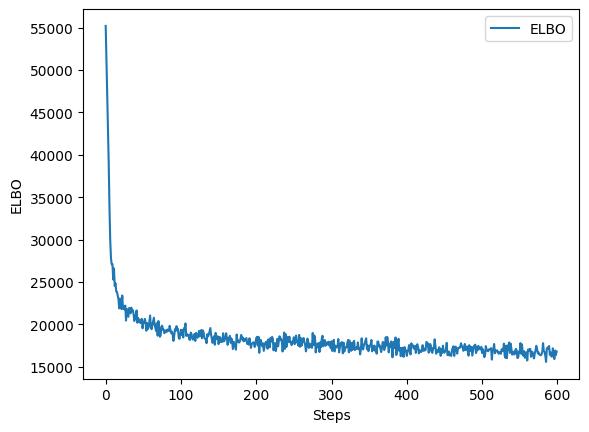

In [10]:
plt.plot(loss_record, label = "ELBO") 
plt.xlabel("Steps") 
plt.ylabel("ELBO") 
plt.legend()
plt.savefig("ELBO LOSS FUNCTION.png", dpi = 300)
plt.show()

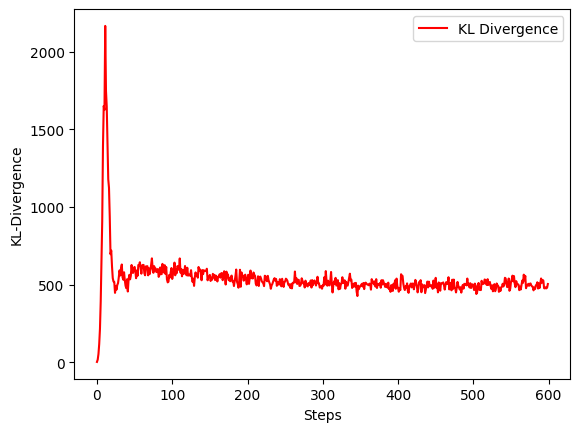

In [11]:
plt.plot(KL_loss, color = 'red', label = 'KL Divergence')
plt.xlabel("Steps") 
plt.ylabel("KL-Divergence") 
plt.legend()
plt.savefig("KL-DIVERGENCE
plt.show() 

# Testing Reconstruction and Generation Performance 

In [17]:
# Function to reconstruct real MNIST images
def reconstruct_images(vae, data_loader, n_images=10):
    real_images, reconstructed_images = [], []
    vae.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(torch.float32)
            recon_batch, _, _ = vae(data)
            real_images = data[:n_images].view(-1, 1, 28, 28)
            reconstructed_images = recon_batch[:n_images].view(-1, 1, 28, 28)
            break
    return real_images, reconstructed_images

# Function to generate new images by sampling from the latent space
def generate_images(vae, n_images=10, latent_dim=2):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(n_images, latent_dim)
        generated_images = vae.decode(z).view(-1, 1, 28, 28)
    return generated_images

# Display function to compare images
def display_image_comparison(real_images, reconstructed_images, generated_images):
    fig, axs = plt.subplots(3, len(real_images), figsize=(12, 6))

    for i in range(len(real_images)):
        axs[0, i].imshow(real_images[i].squeeze().cpu().numpy(), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title("Real")

        axs[1, i].imshow(reconstructed_images[i].squeeze().cpu().numpy(), cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title("Reconstructed", fontsize = 11)

        axs[2, i].imshow(generated_images[i].squeeze().cpu().numpy(), cmap='gray')
        axs[2, i].axis('off')
        axs[2, i].set_title("Generated")

    plt.tight_layout()
    plt.savefig("VAE Sample Images.png", dpi = 300) 
    print("Saved image!") 
    plt.show()



Saved image!


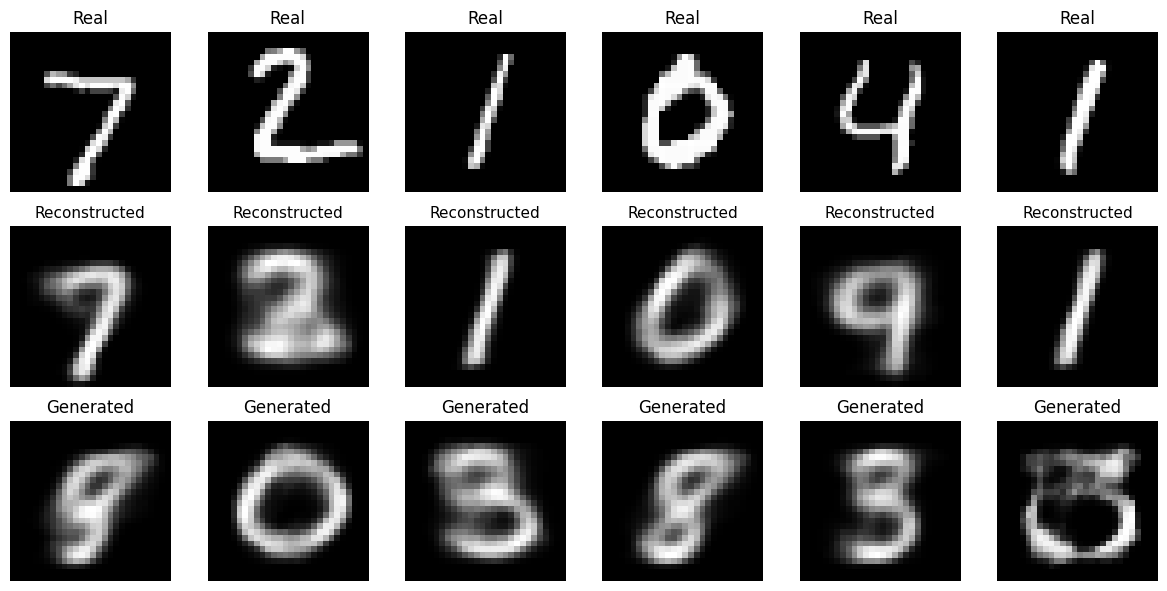

In [18]:
# Load trained VAE model and DataLoader for MNIST
# Reconstruct and generate images
n_images = 6  # Number of images to display
real_images, reconstructed_images = reconstruct_images(model, test_loader, n_images)
generated_images = generate_images(model, n_images, latent_dim=2)

# Display comparison
display_image_comparison(real_images, reconstructed_images, generated_images)


# ANOMALY DETECTION 

Let's generate the 

In [35]:
def add_noise(images, noise_factor = 0.5): 
    noisy_images = images + noise_factor * torch.rand(*images.shape) 
    noisy_images = torch.clip(noisy_images, 0, 1) 
    return noisy_images
    

In [63]:
# Generate normal images and noisy iamges 
test_real, test_recon = reconstruct_images(model, train_loader, n_images = 1) 
noise_real = add_noise(test_real) 


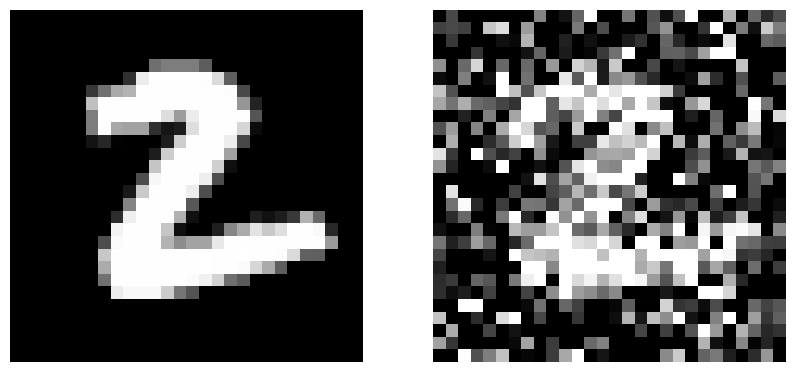

In [65]:
fig, axs = plt.subplots(ncols = 2, figsize = (10, 5)) 
axs[0].imshow(np.squeeze(test_real), cmap = 'gray', vmin = 0, vmax = 1) 
axs[0].axis('off') 
axs[1].imshow(np.squeeze(noise_real), cmap = 'gray', vmin = 0, vmax = 1)
axs[1].axis('off') 

plt.savefig("Normal Vs Corrupted Image.png", dpi = 300) 
plt.show()

In [82]:
# Function to add noise to MNIST images for anomaly testing
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn(*images.shape)
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

# Function to compute reconstruction error for a batch of images
def compute_reconstruction_error(vae, images):
    images = images.to(torch.float32).reshape(-1, 28*28)
    with torch.no_grad():
        recon_images, _, _ = vae(images)
        error = ((recon_images - images) ** 2).sum(dim=(1))
    return error.cpu().numpy()

# Set up normal and anomalous test data
def detect_anomalies(vae, data_loader, noise_factor=0.5):
    normal_errors, anomalous_errors = [], []
    vae.eval()

    # Compute reconstruction errors for normal images
    for data, _ in data_loader:
        errors = compute_reconstruction_error(vae, data)
        normal_errors.extend(errors)
    
    # Create noisy images and compute reconstruction errors for them
    for data, _ in data_loader:
        noisy_data = add_noise(data, noise_factor)
        errors = compute_reconstruction_error(vae, noisy_data)
        anomalous_errors.extend(errors)
        if len(anomalous_errors) >= len(normal_errors):  # Limit size for fair comparison
            anomalous_errors = anomalous_errors[:len(normal_errors)]
            break

    return np.array(normal_errors), np.array(anomalous_errors)

# Plot reconstruction error distributions and set anomaly threshold
def plot_error_distributions(normal_errors, anomalous_errors, threshold_line_val):
    plt.figure(figsize=(10, 6))
    plt.hist(normal_errors, bins=50, alpha=0.6, color='blue', label='Normal')
    plt.hist(anomalous_errors, bins=50, alpha=0.6, color='red', label='Anomalous')
    plt.vlines(threshold_line_val, ymin = 0, ymax = 4500, colors = 'black', label = 'Threshold')  
    
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Distribution of Reconstruction Errors")
    plt.savefig("Distribution of Reconstruction Errors.png", dpi = 300) 
    plt.show()

# Function to classify images based on threshold
def classify_anomalies(errors, threshold):
    return errors > threshold



In [80]:
# Run anomaly detection and classification
normal_errors, anomalous_errors = detect_anomalies(model, train_loader)  


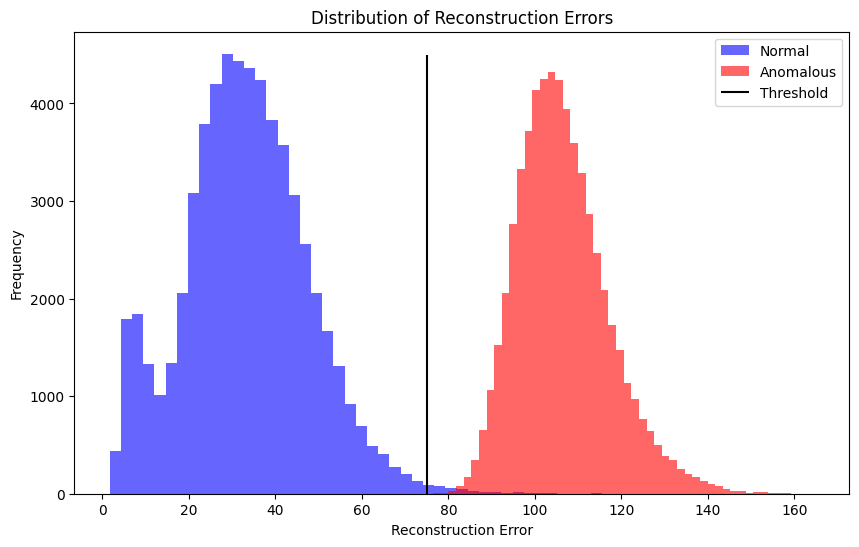

Anomaly threshold set at: 75
False Positive Rate (Normal classified as anomalous): 0.60%
True Positive Rate (Anomalous classified as anomalous): 100.00%


In [84]:
# Determine threshold for anomaly detection
threshold = 75
plot_error_distributions(normal_errors, anomalous_errors, threshold)
print(f"Anomaly threshold set at: {threshold}")

# Classify normal and anomalous images based on threshold
normal_anomalies = classify_anomalies(normal_errors, threshold)
anomalous_anomalies = classify_anomalies(anomalous_errors, threshold)

# Print detection rates
normal_detection_rate = 100 * np.sum(normal_anomalies) / len(normal_anomalies)
anomalous_detection_rate = 100 * np.sum(anomalous_anomalies) / len(anomalous_anomalies)

print(f"False Positive Rate (Normal classified as anomalous): {normal_detection_rate:.2f}%")
print(f"True Positive Rate (Anomalous classified as anomalous): {anomalous_detection_rate:.2f}%")

# Visualzing the Classes in the Latent Space

In [103]:
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=2000, shuffle=False)

In [104]:
# Obtaining the test class 
x_set, y_set = next(iter(test_loader))
x_set = x_set.reshape(-1, 28 * 28) 

In [105]:
len(x_set)

2000

In [106]:
z_set = model.encode(x_set)[0].detach().numpy()

In [107]:
z_set.shape

(2000, 2)

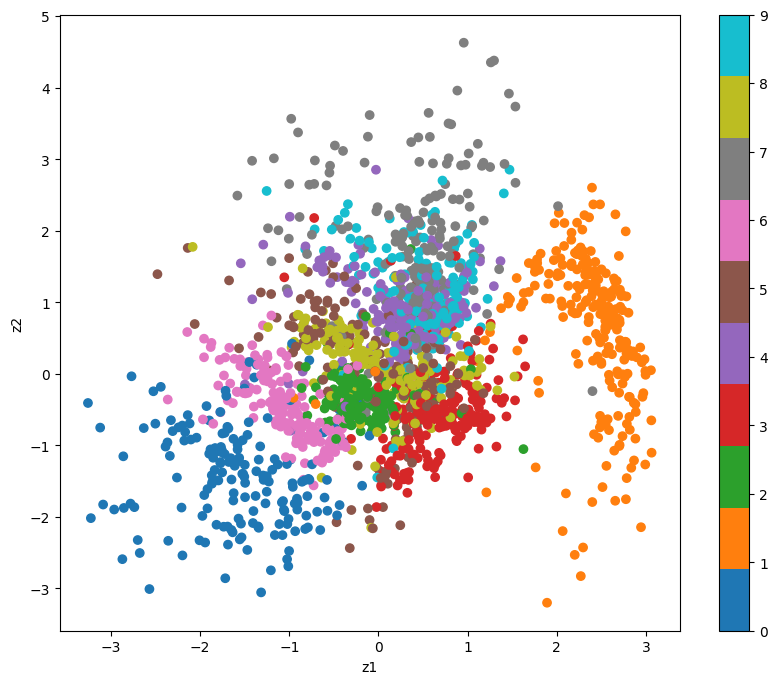

In [116]:
plt.figure(figsize = (10, 8)) 
plt.scatter(z_set[:, 0], z_set[:, 1], c = y_set, cmap = 'tab10')
plt.colorbar()
plt.xlabel('z1') 
plt.ylabel('z2')
plt.savefig("Latent Space Visualization.png", dpi = 300) 
plt.show()